In [1]:
import pandas as pd
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats import spearmanr, kendalltau
import scipy.stats as st
import jinja2
import matplotlib.cm as cm
#from IPython.display import JSON
import math

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('data/data_clean.csv')
df

,kw,rank,link,success,word_count,percent_human,percent_ai
0,how to finish concrete,1,https://www.familyhandyman.com/project/how-to-...,True,1689.0,99.926081,0.073917
1,how to finish concrete,4,https://www.wikihow.com/Finish-Concrete,True,324.0,88.443929,11.556073
2,how to finish concrete,5,https://www.instructables.com/How-to-Finish-Co...,True,1417.0,94.222470,5.777531
3,how to finish concrete,6,https://carrollsbuildingmaterials.com/diy-conc...,True,1600.0,99.730074,0.269922
4,how to finish concrete,7,https://www.hunker.com/13402242/how-to-finish-...,True,738.0,97.359934,2.640062
...,...,...,...,...,...,...,...
14632,ruched midi dress,14,https://www.rihoas.com/collections/ruched-dresses,True,184.0,96.125513,3.874488
14633,ruched midi dress,16,https://www.fashionnova.com/products/my-man-an...,True,1774.0,63.200365,36.799634
14634,ruched midi dress,17,https://www.fashionnova.com/products/my-man-an...,True,1774.0,63.163045,36.836954
14635,ruched midi dress,19,https://www.loft.com/petites/petite-dresses/ca...,True,1602.0,92.680357,7.319643


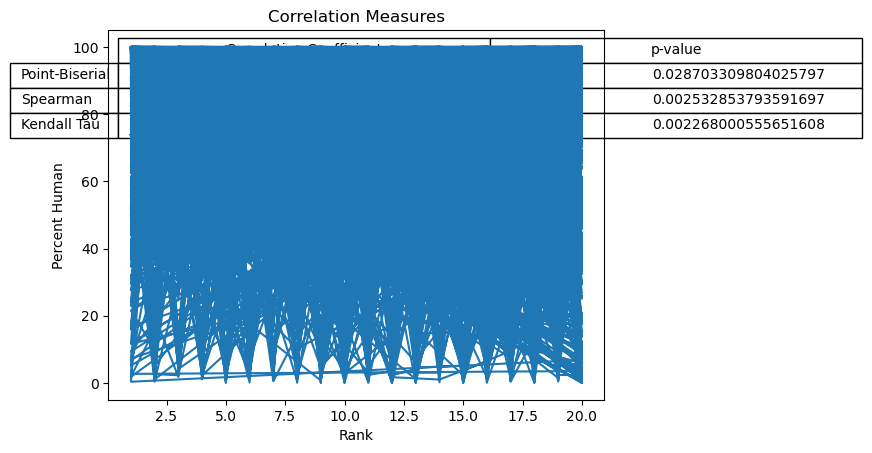

In [4]:
# Assuming your data is stored in a pandas dataframe called 'df'
# and 'Rank' and 'percent_human' are the column names

# Calculate the correlation coefficients and p-values
pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

# Create a pandas dataframe to store the results
data = {'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau], 'p-value': [pb_pval, spearman_pval, kendall_pval]}
index = ['Point-Biserial', 'Spearman', 'Kendall Tau']
df_results = pd.DataFrame(data=data, index=index)

# Create a plot of your data
fig, ax = plt.subplots()
ax.plot(df['rank'], df['percent_human'])

# Create a table as an inset on the plot
cell_text = df_results.values.tolist()
row_labels = df_results.index.tolist()
col_labels = df_results.columns.tolist()

table = ax.table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels, loc='upper left')

# Format the table and plot
table.set_fontsize(10)
table.scale(1.5, 1.5)
ax.set_xlabel('Rank')
ax.set_ylabel('Percent Human')
ax.set_title('Correlation Measures')

plt.show()


In [5]:
#df['log_p_h'] = math.log10(df['percent_human'])

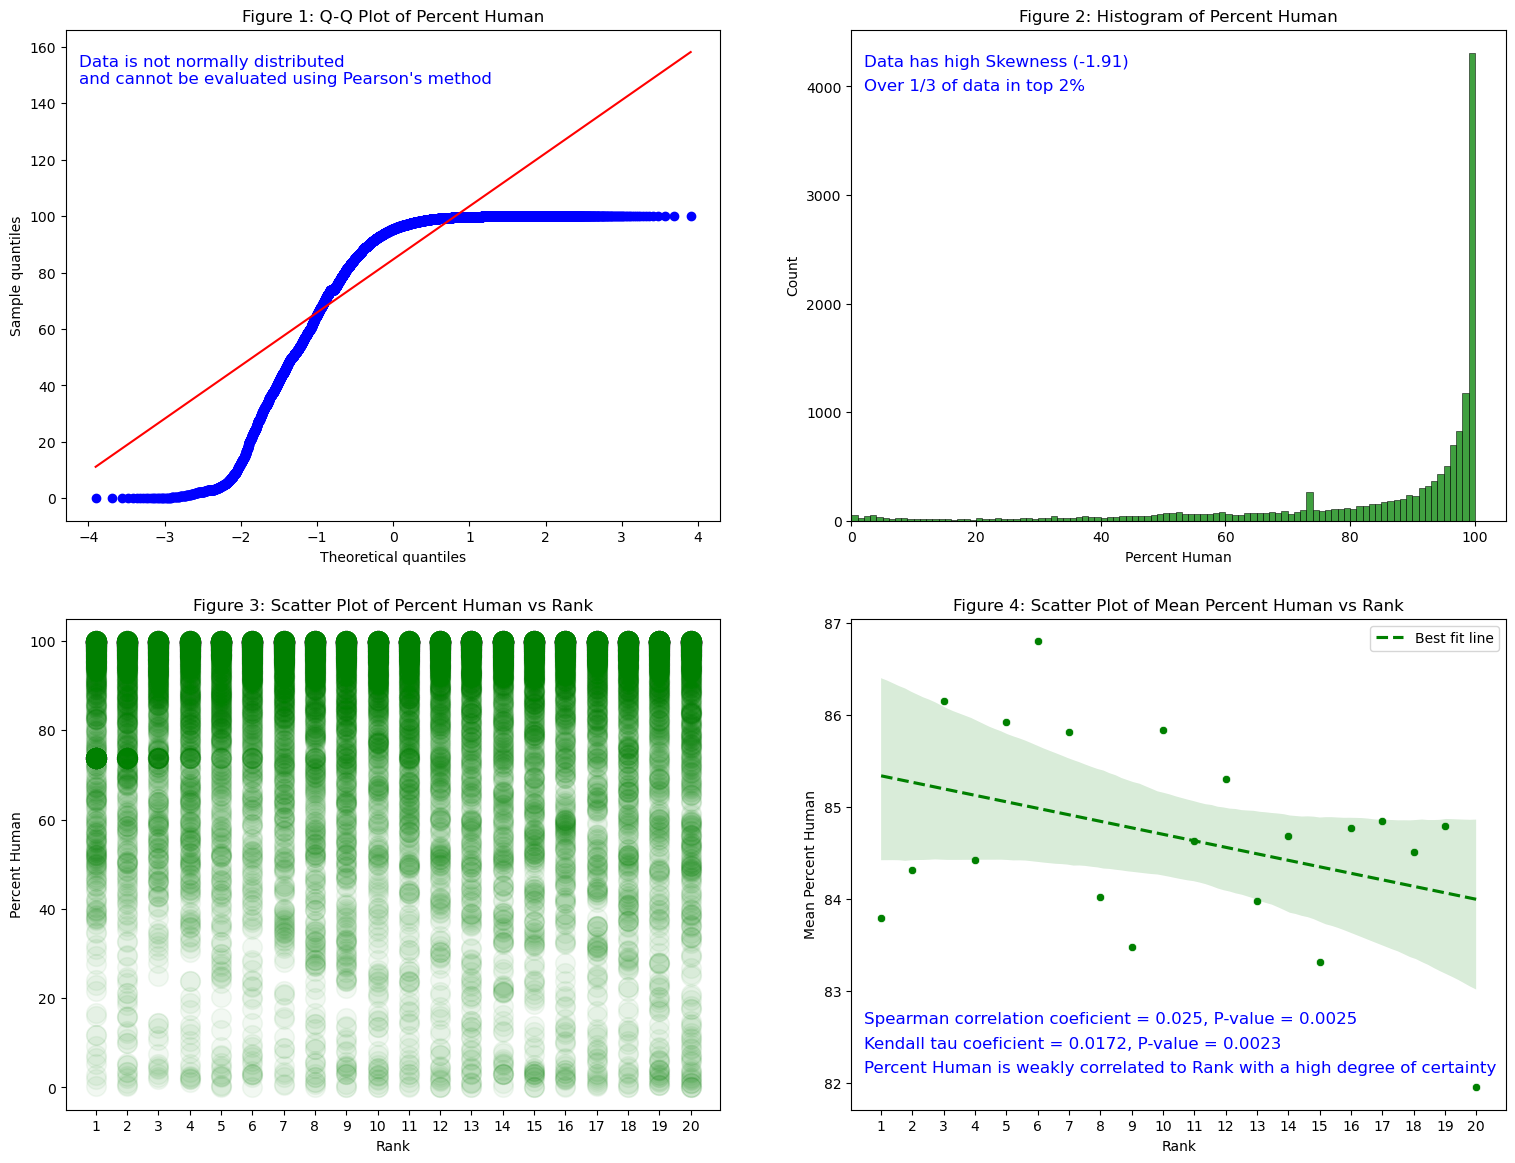

In [6]:
# define subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
# Q-Q plot
st.probplot(df['percent_human'], dist='norm', plot=axs[0, 0])
axs[0, 0].set_title('Figure 1: Q-Q Plot of Percent Human')
axs[0, 0].set_xlabel('Theoretical quantiles')
axs[0, 0].set_ylabel('Sample quantiles')
axs[0, 0].text(0.02, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='blue')

# Histogram
skewness = round(st.skew(df['percent_human']),2)
sns.histplot(data=df['percent_human'], kde=False, binwidth=1, color='green', ax=axs[0, 1])
axs[0, 1].set_title('Figure 2: Histogram of Percent Human')
axs[0, 1].set_xlabel('Percent Human')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_xlim(0, None)
axs[0, 1].set_ylim(0, None)
axs[0, 1].text(0.02, 0.95, f'Data has high Skewness ({skewness})', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='blue')
axs[0, 1].text(0.02, 0.90, f'Over 1/3 of data in top 2%', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color='blue')


# Scatter plot of percent_human vs rank
sns.scatterplot(data=df, x='rank', y='percent_human', color='green', alpha=0.05, s=200, edgecolor=None, ax=axs[1, 0])
axs[1, 0].set_title('Figure 3: Scatter Plot of Percent Human vs Rank')
axs[1, 0].set_xlabel('Rank')
axs[1, 0].set_ylabel('Percent Human')
axs[1, 0].set_xticks(np.arange(1, 21))

# Scatter plot of mean percent_human vs. rank
spear_corr, spear_pval = tuple(round(x, 4) for x in st.spearmanr(df['rank'], df['percent_human']))
#spear_corr, spear_pval = st.spearmanr(df['rank'], df['percent_human'])
#ken_tau, ken_pval = st.kendalltau(df['rank'], df['percent_human'])
ken_tau, ken_pval = tuple(round(x, 4) for x in st.kendalltau(df['rank'], df['percent_human']))
grouped_data = df.groupby('rank')
mean_percent_human = grouped_data['percent_human'].mean().reset_index()
sns.scatterplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human',  color='green')
sns.regplot(ax=axs[1, 1], data=mean_percent_human, x='rank', y='percent_human', color='green', scatter=False, line_kws={'linestyle':'--'})
axs[1, 1].set_title('Figure 4: Scatter Plot of Mean Percent Human vs Rank')
axs[1, 1].set_xlabel('Rank')
axs[1, 1].set_ylabel('Mean Percent Human')
axs[1, 1].set_xticks(np.arange(1, 21))
axs[1, 1].legend(handles=axs[1, 1].lines[::len(mean_percent_human)], labels=['Best fit line'])
axs[1, 1].text(0.02, 0.20, f'Spearman correlation coeficient = {spear_corr}, P-value = {spear_pval}', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color='blue')
axs[1, 1].text(0.02, 0.15, f'Kendall tau coeficient = {ken_tau}, P-value = {ken_pval}', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color='blue')
axs[1, 1].text(0.02, 0.10, f'Percent Human is weakly correlated to Rank with a high degree of certainty', transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color='blue')
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.savefig('figures/Fig_1-4.png')
plt.show()

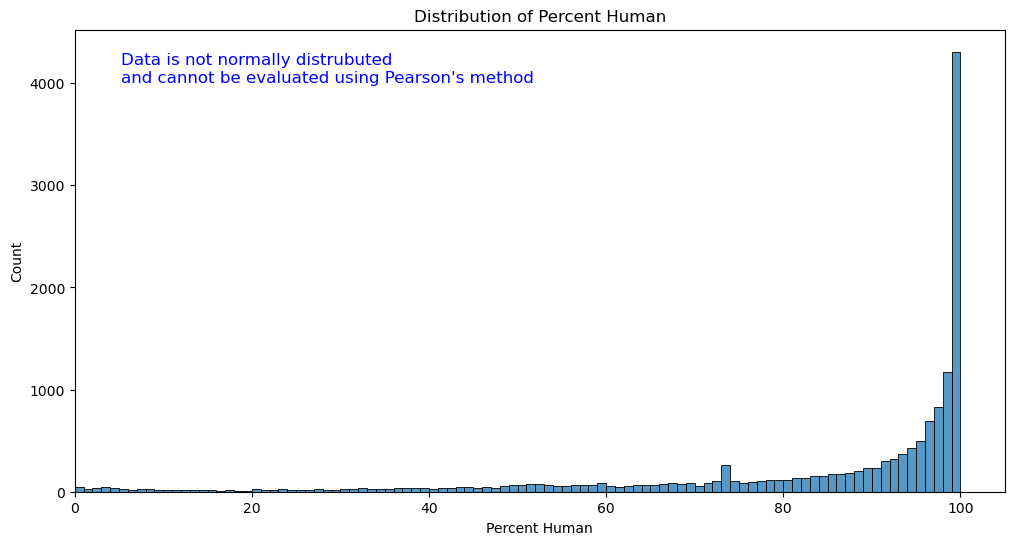

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(df['percent_human'], kde=False, binwidth=1)
ax.set(title='Distribution of Percent Human', xlabel='Percent Human', ylabel='Count', xlim=(0, None), ylim=(0, None))
ax.text(0.05, 0.95, 'Data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')
plt.show()

In [8]:
df['word_count'].max()

183712.0

/home/mike/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


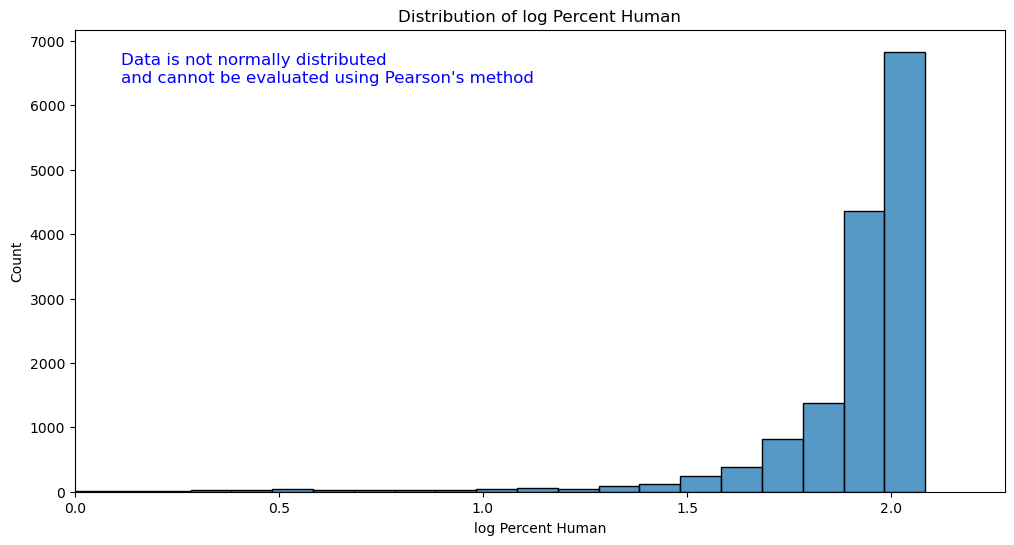

In [9]:
# Calculate the log base 10 of percent_human
df['log_percent_human'] = np.log10(df['percent_human'])

# Create the histogram plot
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(df['log_percent_human'], kde=False, binwidth=0.1)

# Set the plot properties
ax.set(title='Distribution of log Percent Human', xlabel='log Percent Human', ylabel='Count', xlim=(0, None), ylim=(0, None))
ax.text(0.05, 0.95, 'Data is not normally distributed\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')

plt.show()

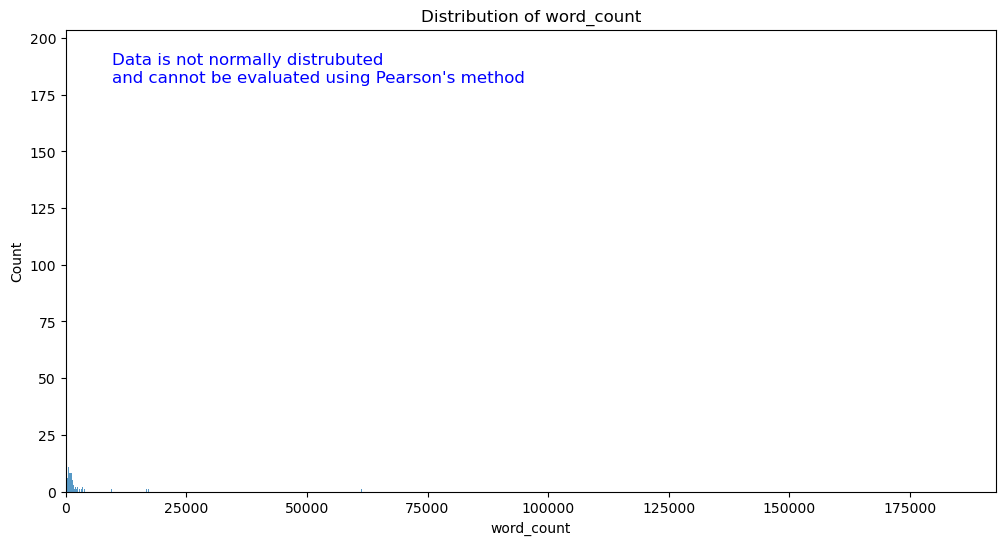

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(df['word_count'], kde=False, binwidth=1)
ax.set(title='Distribution of word_count', xlabel='word_count', ylabel='Count', xlim=(0, None), ylim=(0, None))
ax.text(0.05, 0.95, 'Data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')
plt.show()

In [11]:
df[df['word_count'] <120].count()

kw                   383
rank                 383
link                 383
success              383
word_count           383
percent_human        383
percent_ai           383
log_percent_human    383
dtype: int64

In [12]:
# assuming your DataFrame is named df
df2 = df[(df['word_count'] < 5000) & (df['word_count'] > 150)]

In [13]:
df2['word_count'].mean()

1193.1025660264106

In [14]:
df['word_count'].skew()

22.13212845560128

In [15]:
df2['word_count'].skew()

1.4788125730672794

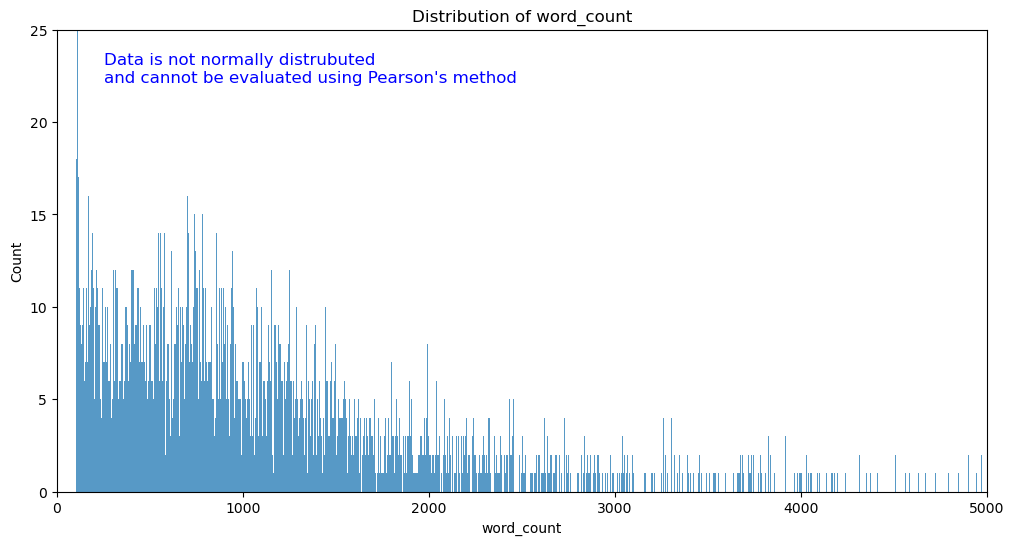

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(df['word_count'], kde=False, binwidth=1)
ax.set(title='Distribution of word_count', xlabel='word_count', ylabel='Count', xlim=(0, 5000), ylim=(0, 25))
ax.text(0.05, 0.95, 'Data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')
plt.show()

In [17]:
skewness = st.skew(df['percent_human'])
skewness

-1.9087443627144547

In [18]:
skewness = st.skew(df['rank'])
skewness

-0.0008983579904216455

In [19]:
(1197+4278)/df.count()

kw                   0.374052
rank                 0.374052
link                 0.374052
success              0.374052
word_count           0.374052
percent_human        0.374052
percent_ai           0.374052
log_percent_human    0.374052
dtype: float64

In [20]:
bins = pd.interval_range(start=0, end=100, freq=1)
bin_counts = pd.cut(df['percent_human'], bins).value_counts()
df_bin = bin_counts.to_frame()
df_bin

,percent_human
"(99, 100]",4278
"(98, 99]",1187
"(97, 98]",825
"(96, 97]",703
"(95, 96]",503
...,...
"(24, 25]",13
"(26, 27]",13
"(18, 19]",9
"(19, 20]",9


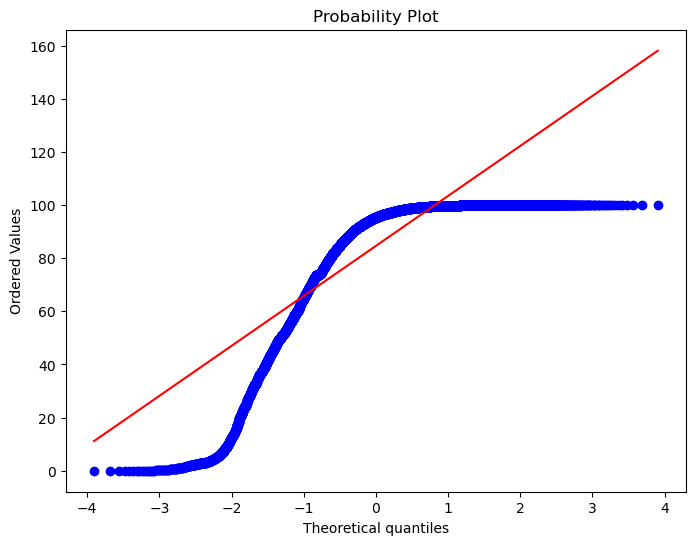

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(df['percent_human'], dist='norm', plot=plt)
plt.show()

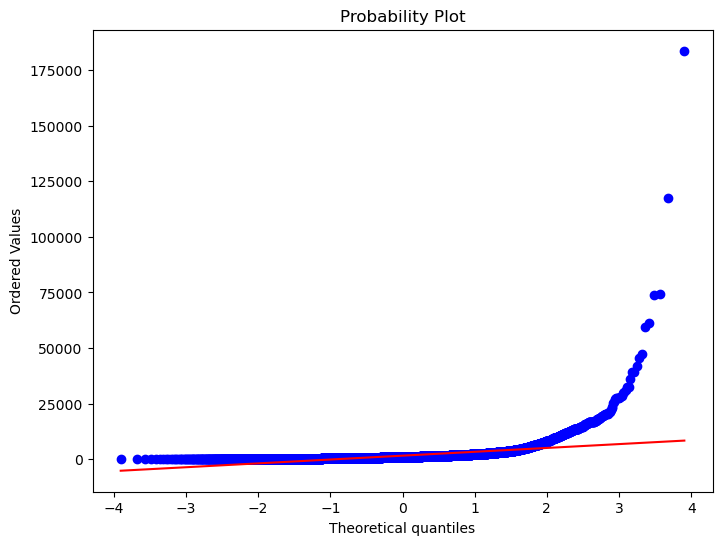

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(df['word_count'], dist='norm', plot=plt)
plt.show()

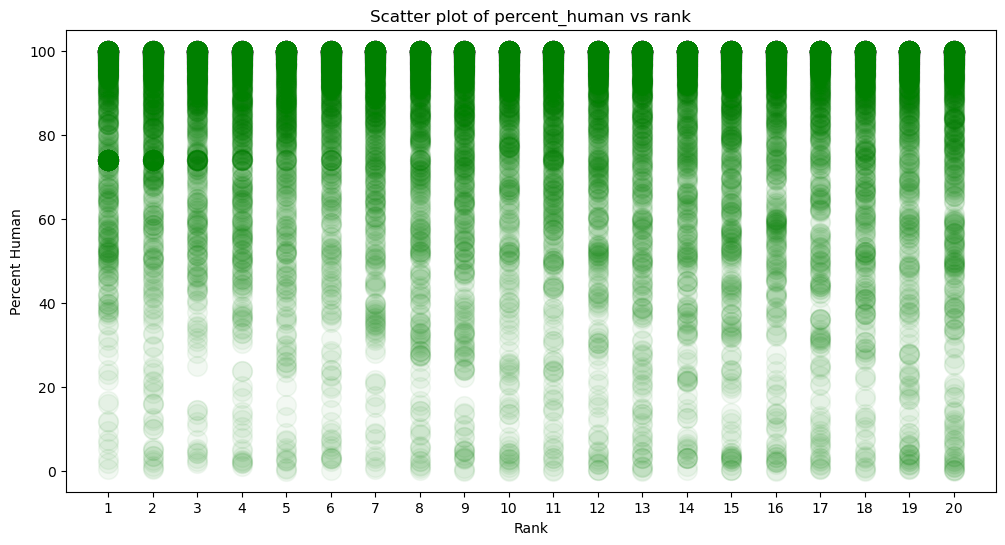

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df, x='rank', y='percent_human', color='green', alpha=0.05, s=200, edgecolor=None)
ax.set_title('Scatter plot of percent_human vs rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Percent Human')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.show()

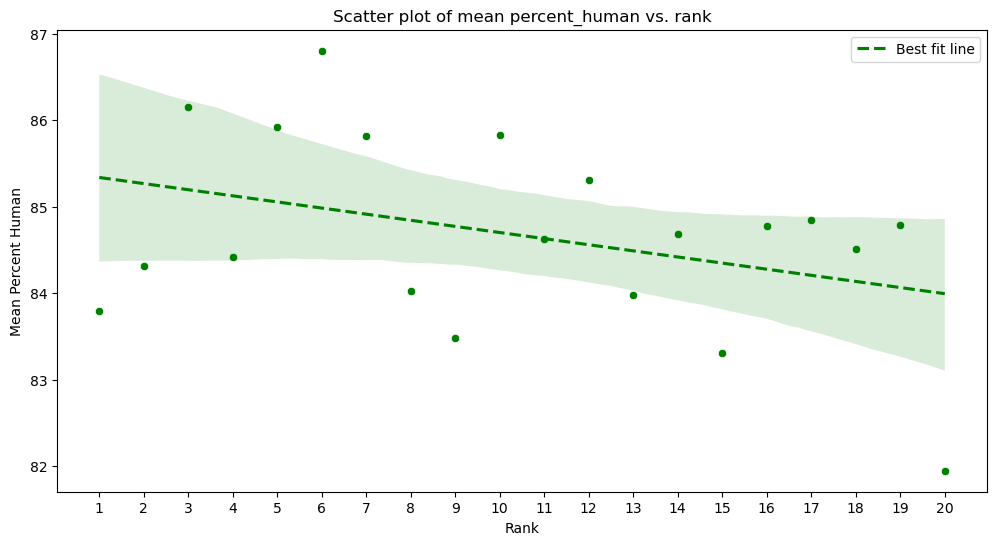

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped_data = df.groupby('rank')
mean_percent_human = grouped_data['percent_human'].mean().reset_index()
sns.scatterplot(ax=ax, x='rank', y='percent_human', data=mean_percent_human, color='green')
sns.regplot(ax=ax, x='rank', y='percent_human', data=mean_percent_human, color='green', scatter=False, line_kws={'linestyle':'--'})
ax.set_title('Scatter plot of mean percent_human vs. rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Percent Human')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
ax.legend(handles=ax.lines[::len(mean_percent_human)], labels=['Best fit line'])
plt.show()


In [26]:
# Calculate the correlation coefficients and p-values
pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])
spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])

# Create a pandas dataframe to store the results
data = {'Correlation Coefficient': [pb_corr, spearman_corr, kendall_tau], 'p-value': [pb_pval, spearman_pval, kendall_pval]}
index = ['Point-Biserial', 'Spearman', 'Kendall Tau']
df_results = pd.DataFrame(data=data, index=index)

# Print the results dataframe
print(df_results)

                Correlation Coefficient   p-value
Point-Biserial                -0.018081  0.028703
Spearman                       0.024955  0.002533
Kendall Tau                    0.017242  0.002268


In [27]:
# Calculate the point-biserial correlation coefficient and p-value
pb_corr, pb_pval = st.pointbiserialr(df['rank'], df['percent_human'])

print("Point-biserial correlation coefficient: {:.3f}".format(pb_corr))
print("p-value: {:.3f}".format(pb_pval))

Point-biserial correlation coefficient: -0.018
p-value: 0.029


In [28]:
spearman_corr, spearman_pval = st.spearmanr(df['rank'], df['percent_human'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: 0.02495527958361103
p-value: 0.002532853793591697


In [29]:
kendall_tau, kendall_pval = st.kendalltau(df['rank'], df['percent_human'])
print("Kendall's Tau correlation:", kendall_tau)
print("p-value:", kendall_pval)

Kendall's Tau correlation: 0.017242445407663405
p-value: 0.002268000555651608


In [30]:
spearman_corr, spearman_pval = st.spearmanr(df['percent_human'], df['word_count'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: -0.114001937195072
p-value: 1.5392917531131827e-43


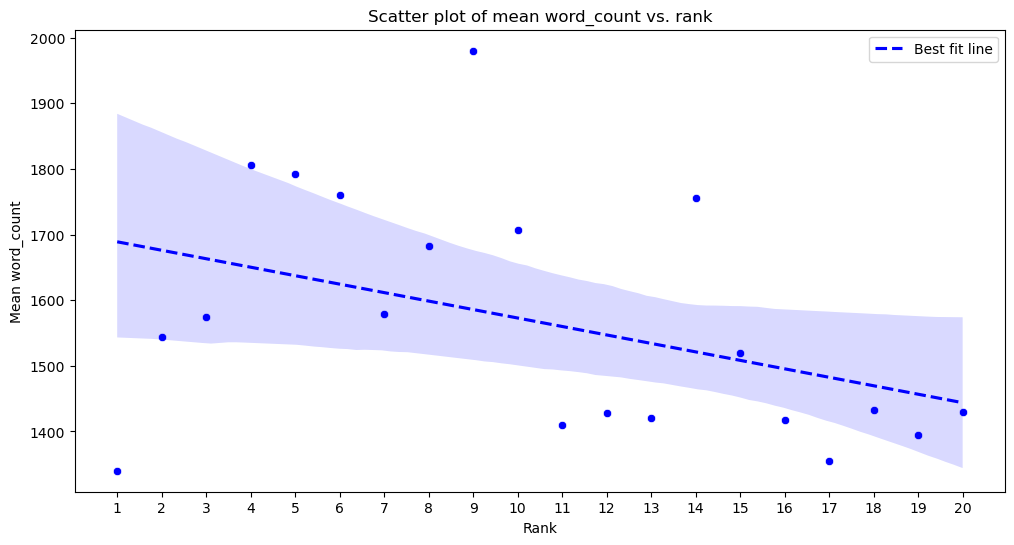

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped_data = df.groupby('rank')
mean_percent_human = grouped_data['word_count'].mean().reset_index()
sns.scatterplot(ax=ax, x='rank', y='word_count', data=mean_percent_human, color='blue')
sns.regplot(ax=ax, x='rank', y='word_count', data=mean_percent_human, color='blue', scatter=False, line_kws={'linestyle':'--'})
ax.set_title('Scatter plot of mean word_count vs. rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean word_count')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
ax.legend(handles=ax.lines[::len(mean_percent_human)], labels=['Best fit line'])
plt.show()

In [32]:
correlations = df.groupby('kw')[['rank', 'percent_human']].corr()
correlations

rank  percent_human
kw                                                           
/lh meaning            rank           1.000000       0.074228
                       percent_human  0.074228       1.000000
2 pole breaker         rank           1.000000      -0.012722
                       percent_human -0.012722       1.000000
205/75r14 trailer tire rank           1.000000       0.003305
...                                        ...            ...
yor forger cosplay     percent_human -0.140728       1.000000
zinus bed frame        rank           1.000000      -0.221257
                       percent_human -0.221257       1.000000
zip up bedding         rank           1.000000       0.369372
                       percent_human  0.369372       1.000000

[2000 rows x 2 columns]

In [33]:
correlations = df.groupby('kw')[['rank', 'percent_human', 'word_count']].corr().iloc[::2,-1].to_frame()
correlations

word_count
kw                                              
/lh meaning            rank            -0.279160
                       word_count       1.000000
2 pole breaker         percent_human   -0.808909
205/75r14 trailer tire rank             0.677676
                       word_count       1.000000
...                                          ...
yoni pearls            word_count       1.000000
yor forger cosplay     percent_human   -0.316037
zinus bed frame        rank             0.456368
                       word_count       1.000000
zip up bedding         percent_human   -0.687084

[1500 rows x 1 columns]

In [34]:
correlations = df[['rank', 'word_count', 'percent_human']].corr(method='spearman').iloc[1::3, :]
correlations

,rank,word_count,percent_human
word_count,-0.074348,1.0,-0.114002


In [35]:
correlations = df.groupby('kw')[['rank', 'percent_human', 'word_count']].corr(method='spearman').unstack()[['rank', 'percent_human', 'word_count']].iloc[1::3, :]
correlations

rank                           \
                                               rank percent_human word_count   
kw                                                                             
2 pole breaker                                  1.0      0.203596  -0.706599   
3 subject notebook                              1.0     -0.261905   0.190476   
707 street                                      1.0      0.542857  -0.714286   
9 year anniversary gift traditional and modern  1.0      0.088235  -0.597059   
acid reflux treatment at home                   1.0      0.186791  -0.374613   
...                                             ...           ...        ...   
world health organization travel passport       1.0     -0.276961   0.063725   
xel 3a cardholder cases                         1.0      0.800000   0.600000   
yard landscaping                                1.0     -0.120879  -0.331868   
yellow crookneck squash                         1.0     -0.038235  -0.282353   
yor forger cosplay                              1.0      0.010989  -0.423077   

                                               percent_human                \
                                                        rank percent_human   
kw                                                                           
2 pole breaker                                      0.203596           1.0   
3 subject notebook                                 -0.261905           1.0   
707 street                                          0.542857           1.0   
9 year anniversary gift traditional and modern      0.088235           1.0   
acid reflux treatment at home                       0.186791           1.0   
...                                                      ...           ...   
world health organization travel passport          -0.276961           1.0   
xel 3a cardholder cases                             0.800000           1.0   
yard landscaping                                   -0.120879           1.0   
yellow crookneck squash                            -0.038235           1.0   
yor forger cosplay                                  0.010989           1.0   

                                                          word_count  \
                                               word_count       rank   
kw                                                                     
2 pole breaker                                  -0.614458  -0.706599   
3 subject notebook                              -0.261905   0.190476   
707 street                                       0.028571  -0.714286   
9 year anniversary gift traditional and modern  -0.617647  -0.597059   
acid reflux treatment at home                   -0.702786  -0.374613   
...                                                   ...        ...   
world health organization travel passport       -0.071078   0.063725   
xel 3a cardholder cases                          0.800000   0.600000   
yard landscaping                                 0.059341  -0.331868   
yellow crookneck squash                         -0.073529  -0.282353   
yor forger cosplay                              -0.192308  -0.423077   

                                                                         
                                               percent_human word_count  
kw                                                                       
2 pole breaker                                     -0.614458        1.0  
3 subject notebook                                 -0.261905        1.0  
707 street                                          0.028571        1.0  
9 year anniversary gift traditional and modern     -0.617647        1.0  
acid reflux treatment at home                      -0.702786        1.0  
...                                                      ...        ...  
world health organization travel passport          -0.071078        1.0  
xel 3a cardholder cases                             0.800000        1.0  
yard lands

In [37]:
correlations = df.groupby('kw')[['rank', 'percent_human', 'word_count']].corr(method='spearman').unstack().iloc[:, 1::3]
correlations

,rank,percent_human,word_count
,percent_human,percent_human,percent_human
kw,,,
/lh meaning,0.180518,1.0,0.137746
2 pole breaker,0.203596,1.0,-0.614458
205/75r14 trailer tire,-0.178571,1.0,-0.214286
21 lessons for the 21st century,-0.381818,1.0,-0.281818
3 subject notebook,-0.261905,1.0,-0.261905
...,...,...,...
yellow slip dress,-0.285714,1.0,-0.619048
yoni pearls,-0.432353,1.0,0.102941


In [38]:
correlations

,rank,percent_human,word_count
,percent_human,percent_human,percent_human
kw,,,
/lh meaning,0.180518,1.0,0.137746
2 pole breaker,0.203596,1.0,-0.614458
205/75r14 trailer tire,-0.178571,1.0,-0.214286
21 lessons for the 21st century,-0.381818,1.0,-0.281818
3 subject notebook,-0.261905,1.0,-0.261905
...,...,...,...
yellow slip dress,-0.285714,1.0,-0.619048
yoni pearls,-0.432353,1.0,0.102941


In [39]:
df2 = correlations['rank']['percent_human']
df2

kw
/lh meaning                        0.180518
2 pole breaker                     0.203596
205/75r14 trailer tire            -0.178571
21 lessons for the 21st century   -0.381818
3 subject notebook                -0.261905
                                     ...   
yellow slip dress                 -0.285714
yoni pearls                       -0.432353
yor forger cosplay                 0.010989
zinus bed frame                   -0.090909
zip up bedding                     0.336364
Name: percent_human, Length: 1000, dtype: float64

In [40]:
# assuming your original dataframe is named "df"
df_wc_500 = df[df['word_count'] < 500]


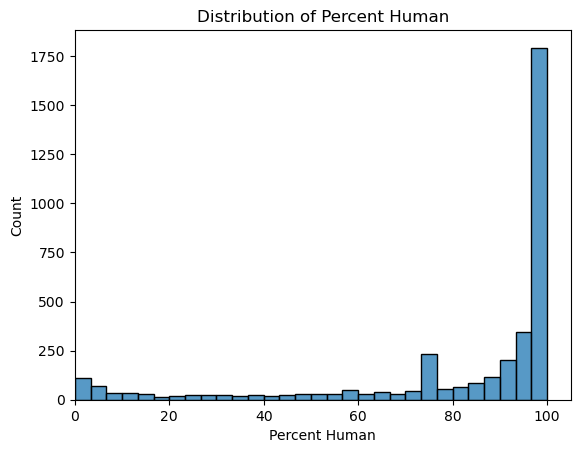

In [41]:
sns.histplot(df_wc_500['percent_human'], kde=False)
plt.title('Distribution of Percent Human')
plt.xlabel('Percent Human')
plt.ylabel('Count')
plt.xlim(0)
plt.ylim(0)
plt.show()

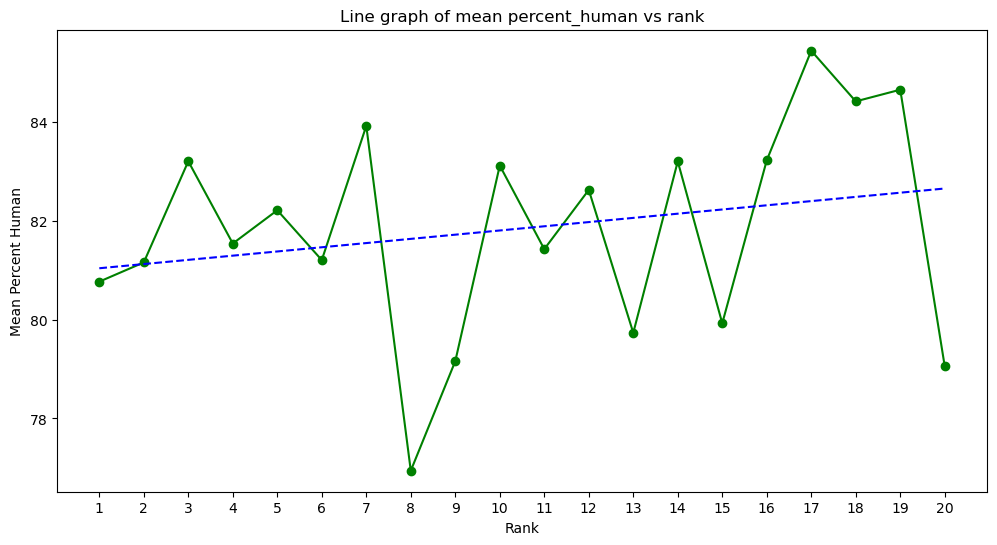

In [42]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Group the data by 'rank'
grouped_data = df_wc_500.groupby('rank')

# Calculate the mean of 'percent_human' for each rank
mean_percent_human = grouped_data['percent_human'].mean()

# Plot the line graph of mean percent_human vs rank
ax.plot(mean_percent_human.index, mean_percent_human, color='green', marker='o')

# Set the title and axis labels
ax.set_title('Line graph of mean percent_human vs rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Percent Human')

# Set the xticks to integers from 1 to 20
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# Add a best fit line
x = mean_percent_human.index
y = mean_percent_human.values
slope, intercept = np.polyfit(x, y, 1)
ax.plot(x, slope*x + intercept, color='blue', linestyle='--')

# Show the plot
plt.show()

In [45]:
spearman_corr, spearman_pval = st.spearmanr(df_wc_500['rank'], df_wc_500['percent_human'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: 0.07069466329593875
p-value: 1.978568343901353e-05


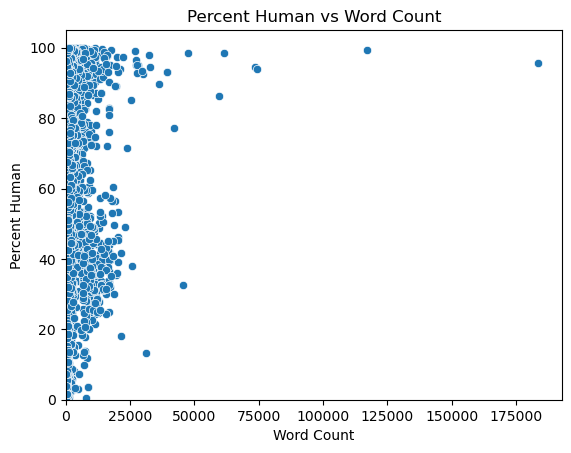

In [46]:
ax = sns.scatterplot(data=df, x='word_count', y='percent_human', hue=None, size=None, style=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None)
ax.set(title='Percent Human vs Word Count', xlabel='Word Count', ylabel='Percent Human', xlim=(0, None), ylim=(0, None))
plt.show()

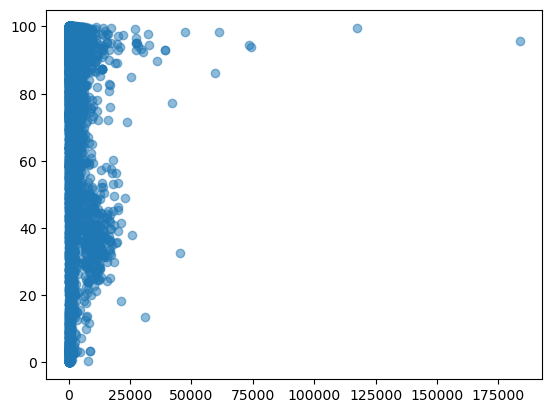

In [48]:
ax = plt.scatter(df['word_count'], df['percent_human'], alpha=0.5)
#ax.set(title='Percent Human vs Word Count', xlabel='Word Count', ylabel='Percent Human', xlim=(0, None), ylim=(0, None))
plt.show()

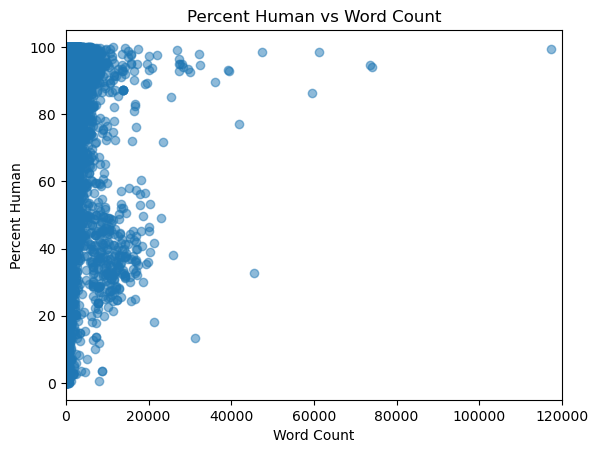

In [49]:
plt.scatter(df['word_count'], df['percent_human'], alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Percent Human')
plt.title('Percent Human vs Word Count')
plt.xlim([0, 120000])  # set x-axis limits
plt.show()

In [51]:
# Create the interval range
bins = pd.interval_range(start=0, end=100, freq=5)

# Create a new column 'bin' that contains the bin labels for each observation
df['bin'] = pd.cut(df['percent_human'], bins)

# Initialize an empty DataFrame to hold the sampled observations
new_df = pd.DataFrame()

# Sample 55 observations from each bin and append them to the new DataFrame
for interval in bins:
    sampled_obs = df[df['bin'] == interval].sample(n=55, replace = False, random_state=42)
    new_df = pd.concat([new_df, sampled_obs])

# Reset the index of the new DataFrame
new_df = new_df.reset_index(drop=True)
new_df


,kw,rank,link,success,word_count,percent_human,percent_ai,log_percent_human,bin
0,goat weed,2,https://www.webmd.com/men/horny-goat-weed-epim...,True,315.0,4.993183,95.006818,0.698377,"(0, 5]"
1,banana trees,14,https://stock.adobe.com/search?k=banana%20tree,True,231.0,3.062132,96.937871,0.486024,"(0, 5]"
2,treehouse for kids,15,https://www.magictreehouse.com/,True,484.0,3.571149,96.428853,0.552808,"(0, 5]"
3,stages of wound healing pictures,6,https://stock.adobe.com/search?k=wound%20healing,True,231.0,3.062132,96.937871,0.486024,"(0, 5]"
4,the lost book of herbal remedies,15,https://carolinareadiness.com/products/the-los...,True,159.0,0.093248,99.906749,-1.030360,"(0, 5]"
...,...,...,...,...,...,...,...,...,...
1095,elephant ear,2,https://hort.extension.wisc.edu/articles/eleph...,True,1499.0,99.879803,0.120196,1.999478,"(95, 100]"
1096,how to repair a hole in drywall,11,https://www.thisoldhouse.com/walls/21015080/ho...,True,423.0,99.967694,0.032312,1.999860,"(95, 100]"
1097,mold removal services,14,https://www.moldmanusa.com/post/what-you-shoul...,True,1118.0,95.937192,4.062804,1.981987,"(95, 100]"
1098,bad acne,10,https://www.healthline.com/health/severe-acne/...,True,1762.0,96.811713,3.188287,1.985928,"(95, 100]"


In [52]:

bins = pd.interval_range(start=0, end=100, freq=5)
df['bin'] = pd.cut(df['percent_human'], bins)

# randomly sample exactly 55 values from each bin
sample_size = 55
new_df = df.groupby('bin').apply(lambda x: x.sample(n=min(len(x), sample_size), random_state=np.random.RandomState(42)) if len(x) >= sample_size else x)

# reset index and drop the original index
new_df = new_df.reset_index(drop=True)

In [53]:
spearman_corr, spearman_pval = st.spearmanr(new_df['rank'], new_df['percent_human'])
print("Spearman correlation:", spearman_corr)
print("p-value:", spearman_pval)

Spearman correlation: -0.10820621888117933
p-value: 0.0003240492974351133


In [54]:
kendall_tau, kendall_pval = st.kendalltau(new_df['rank'], new_df['percent_human'])
print("Kendall's Tau correlation:", kendall_tau)
print("p-value:", kendall_pval)

Kendall's Tau correlation: -0.0738793308149277
p-value: 0.000342099037084246


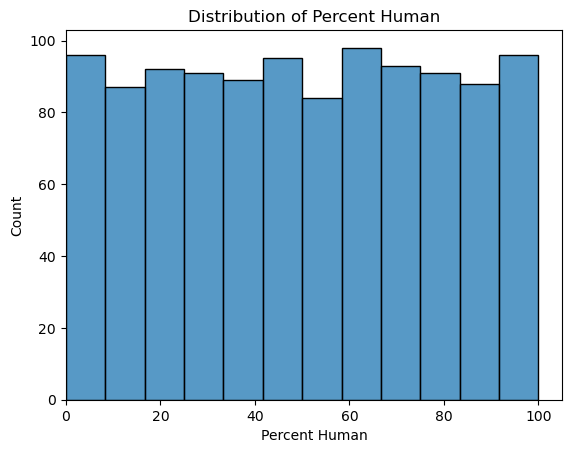

In [55]:
ax = sns.histplot(new_df['percent_human'], kde=False)
ax.set(title='Distribution of Percent Human', xlabel='Percent Human', ylabel='Count', xlim=(0, None), ylim=(0, None))
#ax.text(0.05, 0.95, 'Our data is not normally distrubuted\nand cannot be evaluated using Pearson\'s method', transform=ax.transAxes, fontsize=8, verticalalignment='top', color='blue')
plt.show()

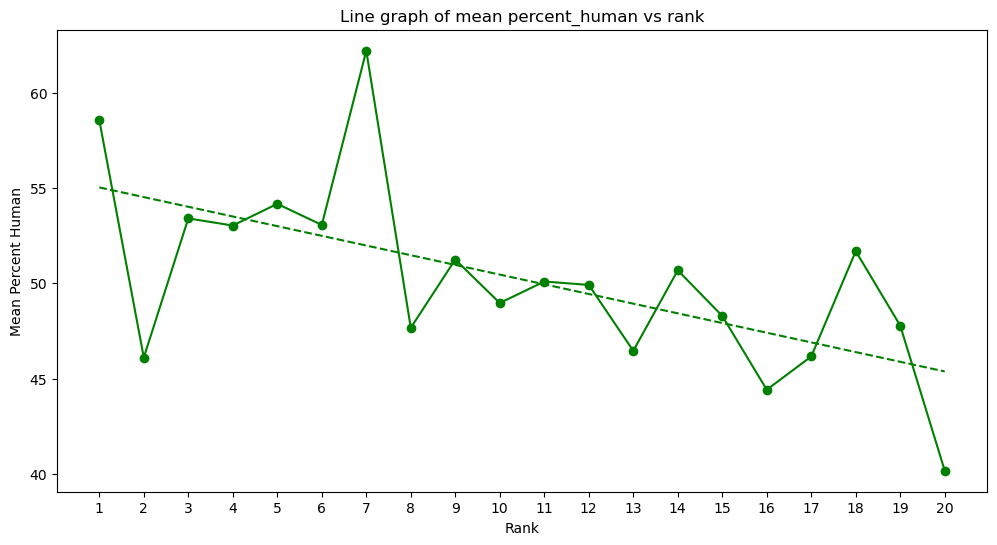

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped_data = new_df.groupby('rank')
mean_percent_human = grouped_data['percent_human'].mean()

ax.plot(mean_percent_human.index, mean_percent_human, color='green', marker='o')

# Set the title and axis labels
ax.set_title('Line graph of mean percent_human vs rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Percent Human')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# Add a best fit line
x = mean_percent_human.index
y = mean_percent_human.values
slope, intercept = np.polyfit(x, y, 1)
ax.plot(x, slope*x + intercept, color='green', linestyle='--')

plt.show()